<a href="https://colab.research.google.com/github/gulabpatel/YOLOs/blob/main/Yolov8_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert and Optimize YOLOv8 with OpenVINO™

The YOLOv8 algorithm is developed by Ultralytics, is a cutting-edge, state-of-the-art (SOTA) model that is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection, image segmentation and image classification tasks.

YOLO stands for “You Only Look Once”, it is a popular family of real-time object detection algorithms. 
The original YOLO object detector was first released in 2016. Since then, different versions and variants of YOLO have been proposed, each providing a significant increase in performance and efficiency.
YOLOv8 builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility.
More details about its realization can be found in original model [repository](https://github.com/ultralytics/ultralytics).

Real-time object detection is often used as a key component in computer vision systems. 
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch\* YOLOv8 with OpenVINO.

The tutorial consists of the following steps:
- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.

## Get Pytorch model

Generally, PyTorch models represent an instance of the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 nano model (also known as `yolov8n`) pretrained on COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). The similar steps are also applicable to other YOLOv8 models.
Typical steps to obtain pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

In this case, the model creators provide an API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR, so we don't need to do these steps manually.

### Prerequisites

Install necessary packages.

In [1]:
!pip install ultralytics==8.0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
try:
    import nncf  # noqa: F401
except ImportError:
    !pip install "git+https://github.com/openvinotoolkit/nncf.git#egg=nncf"

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow


In [3]:
from ultralytics import YOLO
MODEL_NAME = "yolov8n"
model = YOLO(f'{MODEL_NAME}.pt')

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

In [4]:
label_map = model.model.names
label_map

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [5]:
# !wget https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/data/image.zip

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
IMAGE_PATH = "/content/drive/MyDrive/Dataset/yolo8/image/coco_bike.jpg"
results = model(IMAGE_PATH, return_outputs=True)

Ultralytics YOLOv8.0.5 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


In [8]:
image_res = next(results)['det']

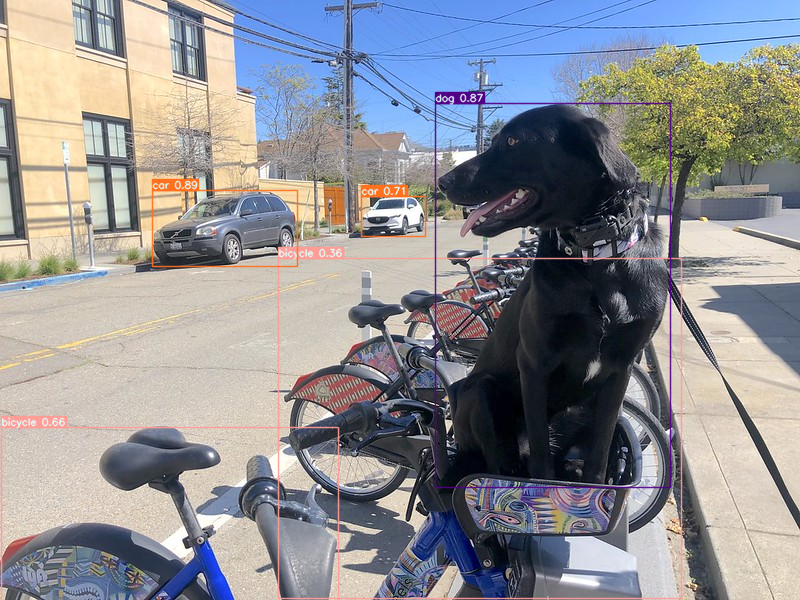

In [9]:
from typing import Tuple
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(box:np.ndarray, img:np.ndarray, color:Tuple[int, int, int] = None, label:str = None, line_thickness:int = 5):
    """
    Helper function for drawing single bounding box on image
    Parameters:
        x (np.ndarray): bounding box coordinates in format [x1, y1, x2, y2]
        img (no.ndarray): input image
        color (Tuple[int, int, int], *optional*, None): color in BGR format for drawing box, if not specified will be selected randomly
        label (str, *optonal*, None): box label string, if not provided will not be provided as drowing result
        line_thickness (int, *optional*, 5): thickness for box drawing lines
    """
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return img


def draw_boxes(image_res:np.ndarray, source_image:np.ndarray):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image_res (np.ndarray): detection predictions in format [x1, y1, x2, y2, score, label_id]
        source_image (np.ndarray): input image for drawing
    Returns:
        
    """
    for *xyxy, conf, cls in reversed(image_res):
        label = f'{label_map[int(cls)]} {conf:.2f}'
        source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(cls)), line_thickness=1)
    return source_image


img = np.array(Image.open(IMAGE_PATH))
img_with_boxes = draw_boxes(image_res, img.copy())
Image.fromarray(img_with_boxes)

## Convert model to OpenVINO IR

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify format and additionally we can preserve dynamic shapes in model.

In [10]:
from pathlib import Path

model_path = Path(f"{MODEL_NAME}_openvino_model/{MODEL_NAME}.xml")
if not model_path.exists():
    model.export(format="openvino", dynamic=True, half=False)

Ultralytics YOLOv8.0.5 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from yolov8n.pt with output shape (1, 84, 8400) (6.2 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.0...
ONNX: export success ✅ 14.4s, saved as yolov8n.onnx (12.1 MB)
requirements: YOLOv8 require

## Verify model inference

To test model work, we create inference pipeline similar to `model.predict` method. Our pipeline consists of preprocessing step, inference of OpenVINO model and results post-processing to get bounding boxes.

In [11]:
from openvino.runtime import Core, Model

core = Core()
ov_model = core.read_model(model_path)
device = "CPU"  # GPU
if device != "CPU":
    ov_model.reshape({0: [1, 3, 640, 640]})
compiled_model = core.compile_model(ov_model, device)

### Preprocessing

Model input is tensor with shape `[-1, 3, -1, -1]` in `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

Model expects images in RGB channels format and normalized in [0, 1] range. Although model supports dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes e.g. 640x640 for better efficiency. To resize images to fit model size `letterbox` resize approach is used where the aspect ratio of width and height is preserved.

To keep specific shape preprocessing automatically enables padding.

In [12]:
from typing import Tuple
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input, 
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints
    
    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size
    
    
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]
    
    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.
    
    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range 
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

### Postprocessing

Model output contains detection boxes candidates, it is a tensor with shape `[-1,84,-1]` in format `B,84,N` where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has format [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`], where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting final prediction, we need to apply non maximum supression algorithm and rescale boxes coordinates to original image size.

In [13]:
def postprocess(preds:np.ndarray, input_hw:Tuple[int, int], orig_img:np.ndarray, min_conf_threshold:float = 0.25, nms_iou_threshold:float = 0.7, agnosting_nms:bool = False, max_detections:int = 300):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        preds (np.ndarray): model output predictions
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
    Returns:
       pred (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    
    preds = ops.non_max_suppression(
        torch.from_numpy(preds),
        min_conf_threshold,
        nms_iou_threshold,
        agnostic=agnosting_nms,
        max_det=max_detections
    )

    for i, pred in enumerate(preds):
        shape = orig_img.shape      
        pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()

    return preds

### Test on single image

Now, when we defined preprocessing and postprocessing steps, we are ready to check model prediction

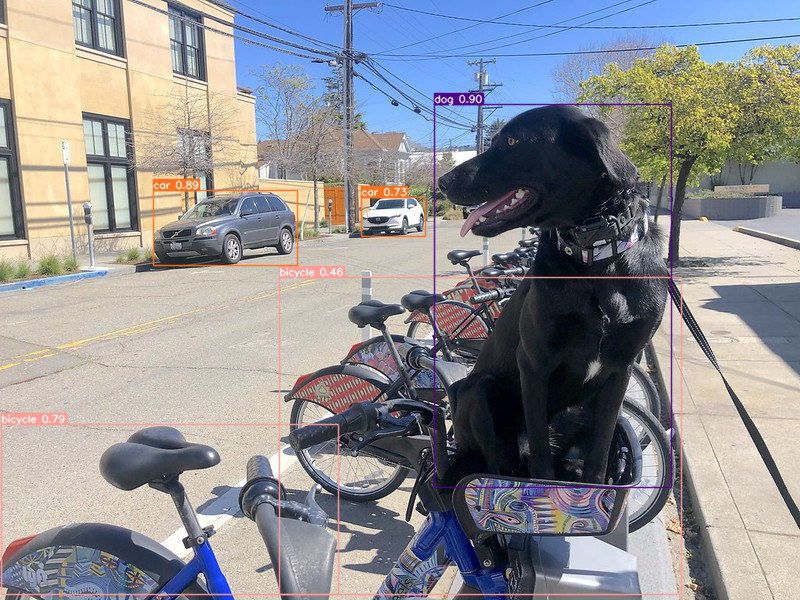

In [14]:
def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_layer = model.output(0)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)[output_layer]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(result, input_hw, image)
    return detections


input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(image_with_boxes)

## Check model accuracy on dataset

For comparing optimized model result with original, it is good to know some measurable results in termins of model accuracy on validation dataset. 


### Download validation dataset

YOLOv8 is pre-trained on the COCO dataset, so in order to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the model author for use with the original model evaluation function.

>**Note**: In the first time, dataset downloading could take some minutes. Downloading speed depends from your internet connection.

In [15]:
import os
import socket
import threading
import time
import urllib
import urllib.parse
import urllib.request
from os import PathLike
from pathlib import Path
from typing import Callable, List, NamedTuple, Optional, Tuple

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from openvino.runtime import Core, get_version
# from async_pipeline import AsyncPipeline
from IPython.display import HTML, Image, Markdown, display
from matplotlib.lines import Line2D
# from models import model
from tqdm.notebook import tqdm_notebook

class DownloadProgressBar(tqdm_notebook):
  def update_to(self, block_num: int, block_size: int, total_size: int):
        downloaded = block_num * block_size
        if downloaded <= total_size:
            self.update(downloaded - self.n)

def download_file(
    url: PathLike,
    filename: PathLike = None,
    directory: PathLike = None,
    show_progress: bool = True,
    silent: bool = False,
    timeout: int = 10,
) -> str:

    try:
        opener = urllib.request.build_opener()
        opener.addheaders = [("User-agent", "Mozilla/5.0")]
        urllib.request.install_opener(opener)
        urlobject = urllib.request.urlopen(url, timeout=timeout)
        if filename is None:
            filename = urlobject.info().get_filename() or Path(urllib.parse.urlparse(url).path).name
    except urllib.error.HTTPError as e:
        raise Exception(f"File downloading failed with error: {e.code} {e.msg}") from None
    except urllib.error.URLError as error:
        if isinstance(error.reason, socket.timeout):
            raise Exception(
            ) from None
        else:
            raise

    filename = Path(filename)
    if len(filename.parts) > 1:
        raise ValueError(
            "`filename` should refer to the name of the file, excluding the directory. "
            "Use the `directory` parameter to specify a target directory for the downloaded file."
        )

    # create the directory if it does not exist, and add the directory to the filename
    if directory is not None:
        directory = Path(directory)
        directory.mkdir(parents=True, exist_ok=True)
        filename = directory / Path(filename)

    # download the file if it does not exist, or if it exists with an incorrect file size
    urlobject_size = int(urlobject.info().get("Content-Length", 0))
    if not filename.exists() or (os.stat(filename).st_size != urlobject_size):
        progress_callback = DownloadProgressBar(
            total=urlobject_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc=str(filename),
            disable=not show_progress,
        )
        urllib.request.urlretrieve(url, filename, reporthook=progress_callback.update_to)
        if os.stat(filename).st_size >= urlobject_size:
            progress_callback.update(urlobject_size - progress_callback.n)
            progress_callback.refresh()
    else:
        if not silent:
            print(f"'{filename}' already exists.")
    return filename.resolve()

In [16]:
import sys
from zipfile import ZipFile

sys.path.append("../utils")
# from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('./datasets')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(OUT_DIR / 'coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(OUT_DIR / 'val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

datasets/val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

datasets/coco2017labels-segments.zip:   0%|          | 0.00/169M [00:00<?, ?B/s]

### Configure DetectionValidator helper and create DataLoader

Original model repository uses `DetectionValidator` wrapper, which represents accuracy validation pipeline. It creates dataloader and evaluation metrics and update metrics on each data batch produced by dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. For class intialization configaration should be provided. We will use default setup, but it can be replaced with some parameters overriding to test on custom data.  

In [17]:
from ultralytics.yolo.utils import DEFAULT_CONFIG
from ultralytics.yolo.configs import get_config
args = get_config(config=DEFAULT_CONFIG)
args.data = "coco.yml"

In [18]:
validator = model.ValidatorClass(args)

In [19]:
data_loader = validator.get_dataloader("datasets/coco", 1)

val: Scanning datasets/coco/labels/val2017... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:04<00:00, 1016.82it/s]
val: New cache created: datasets/coco/labels/val2017.cache


In [20]:
from tqdm.notebook import tqdm
from ultralytics.yolo.utils.metrics import ConfusionMatrix

validator.is_coco = True
validator.class_map = ops.coco80_to_coco91_class()
validator.names = model.model.names
validator.metrics.names = validator.names
validator.nc = model.model.model[-1].nc

### Define validation function

In [21]:
def test(model:Model, core:Core, data_loader:torch.utils.data.DataLoader, num_samples:int = None):
    """
    OpenVINO YOLOv8 model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    model.reshape({0: [1, 3, -1, -1]})
    compiled_model = core.compile_model(model)
    output_layer = compiled_model.output(0)
    for batch_i, batch in enumerate(data_loader):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        preds = torch.from_numpy(compiled_model(batch["img"])[output_layer])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats


def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))

After defintion test function, we are ready for getting detection accuracy metrics
>**Note**: Model evaluation is time consuming process and can take several minutes depends on your hardware. For reducing calculation time, you can define `num_samples` parameter with evaluation subset size, but in this case accuracy can be noncomparable with originally reported by model authors due to validation subset difference.

In [22]:
fp_stats = test(ov_model, core, tqdm(data_loader))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all        5000       36335       0.633       0.474       0.521       0.371


`print_stats` reports following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in dataset,  where `t` is Intersection Over Union (IOU) threshold, degree of overlaping between ground truth and predicted objects.
            So, `mAP@.5` means that mean average precision calculated at 0.5 IOU threshold, `mAP@.5:.95` - calculated on range IOU threshlods from 0.5 to 0.95 with step 0.05.

## Optimize model using NNCF Post-training Quantization API

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

> **Note**: NNCF Post-training Quantization is available as a preview feature in OpenVINO 2022.3 release.
Fully functional support will be provided in the next releases.

The optimization process contains the following steps:

1. Create Dataset for quantization
2. Run `nncf.quantize` for getting optimized model
3. Serialize OpenVINO IR model using `openvino.runtime.serialize` function

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define transformation function for getting only input tensors.

In [24]:
import nncf  # noqa: F811
from typing import Dict


def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(data_loader, transform_fn)

`nncf.quantize` function provides interface for model quantization. It requires instance of OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for configuration quantization process (number of samples for quantization, preset, ignored scope etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achive better result we will use `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate result we should keep operation in postprocessing subgraph in floating point precision using `ignored_scope` parameter.

>**Note**: Model post-training quantization is time consuming process, please be patient, it can take several minutes depending on your hardware.

In [ ]:
quantized_model = nncf.quantize(
    ov_model, 
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED,
    ignored_scope=nncf.IgnoredScope(
        types=["Multiply", "Subtract", "Sigmoid"],  # ignore operations
        names=["/model.22/dfl/conv/Conv",           # in the post-processing subgraph
               "/model.22/Add",
               "/model.22/Add_1",
               "/model.22/Add_2",
               "/model.22/Add_3",
               "/model.22/Add_4",
               "/model.22/Add_5",
               "/model.22/Add_6",
               "/model.22/Add_7",
               "/model.22/Add_8",
               "/model.22/Add_9",
               "/model.22/Add_10"]
    ))

In [ ]:
from openvino.runtime import serialize
int8_model_path = Path(f'{MODEL_NAME}_openvino_int8_model/{MODEL_NAME}.xml')
print(f"Quantized model will be saved to {int8_model_path}")
serialize(quantized_model, str(int8_model_path))

## Validate Quantized model inference

`nncf.quantize` returns OpenVINO Model class instance, which is suitable for loading on device for making predictions. INT8 model input data and output result formats have no difference from floating point model representation, so we can reuse the same `detect` function defined above for getting int8 model result on image.

In [ ]:
if device != "CPU":
    quantized_model.reshape({0, [1, 3, 640, 640]})
quantized_compiled_model = core.compile_model(quantized_model, device)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect(input_image, quantized_compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(image_with_boxes)

## Compare Performance of the Original and Quantized Models
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m $model_path -d CPU -api async -shape "[1,3,640,640]"

In [ ]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m $int8_model_path -d CPU -api async -shape "[1,3,640,640]"

## Validate quantized model accuracy

As we can see, there is not significant difference between int8 and float model result in single image test. To understand how quantization influence on model prediction precision, we can compare model accuracy on dataset.

In [ ]:
int8_stats = test(quantized_model, core, tqdm(data_loader))

In [ ]:
print("FP32 model accuracy")
print_stats(fp_stats, validator.seen, validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_stats, validator.seen, validator.nt_per_class.sum())

Great! Looks like accuracy was changed, but not significally and fulfit passing criteria.

## Live demo

the following code run model inference on video:

In [ ]:
import sys
import collections
import time
from IPython import display
sys.path.append("../utils")
import notebook_utils as utils


# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model=model, device=device):
    player = None
    if device != "CPU":
        model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect(input_image[:, :, ::-1], compiled_model)[0]
            stop_time = time.time()
            
            image_with_boxes = draw_boxes(detections, input_image)
            frame = image_with_boxes
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

## Next steps
This section contains suggestions how to additionally improve perfomance of your application using OpenVINO.

### Asyn inference pipeline
The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (e.g. populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perfom async inference using openvino, please refer to [Async API tutorial](../115-async-api/115-async-api.ipynb)

### Integration preprocessing to model

Preprocessing API allows to make preprocessing a part of model reducing application code and dependency from additional image processing libraries. 
The main advantage of Preprocessing API that preprocessing steps will be integrated into execution graph and will be performed on selected device (CPU/GPU/VPU/etc.) rather than always being executed on CPU as part of application. This will improve selected device utilization.

For more information, refer to the overview of [Preprocessing API](https://docs.openvino.ai/latest/openvino_docs_OV_Runtime_UG_Preprocessing_Overview.html).

For example, we can integrate converting input data layout and normalization defined in `image_to_tensor` function.

The integration process consists of following steps:
1. Initialize PrePostProcessing object
2. Define input data format
3. Describe preprocessing steps
4. Integrating Steps into a Model

#### Initialize PrePostProcessing API

openvino.preprocess.PrePostProcessor class allows specifying preprocessing and postprocessing steps for a model 

In [ ]:
from openvino.preprocess import PrePostProcessor

ppp = PrePostProcessor(quantized_model)

#### Define input data format
To address particular input of a model/preprocessor, method `input(input_id)`, where `input_id` is positional index or input tensor name for input in `model.inputs`, if model has single input `input_id` can be omitted.
After reading image from disc, it contains U8 pixels in [0, 255] range and stored in `NHWC`layout. To perform preprocessing conversion, we should provide this to tensor description.

In [ ]:
from openvino.runtime import Type, Layout

ppp.input(0).tensor().set_shape([1, 640, 640, 3]).set_element_type(Type.u8).set_layout(Layout('NHWC'))
pass

To perform layout conversion, we also should provide information about layout expected by model

#### Describe preprocessing steps

Our preprocessing function contains following steps
* Convert data type from `U8` to `FP32`
* Convert data layout from `NHWC` to `NCHW` format
* Normalize each pixel by dividing on scale factor 255

`ppp.input(input_id).preprocess()` used for defining sequence of preprocessing steps:

In [ ]:
ppp.input(0).preprocess().convert_element_type(Type.f32).convert_layout(Layout('NCHW')).scale([255., 255., 255.])

print(ppp)

#### Integrating Steps into a Model

Once the preprocessing steps have been finished the model can be finally built. Additionally we can save completed model to OpenVINO IR using `openvino.runtime.serialize`.

In [ ]:
quantized_model_with_preprocess = ppp.build()
serialize(quantized_model_with_preprocess, str(int8_model_path.with_name(f"{MODEL_NAME}_with_preprocess.xml")))

Model with integrated preprocessing is ready for loading to device. Now, we can skip these preprocessing steps in detect function

In [ ]:
def detect_without_preprocess(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model with integrated preprocessing inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    output_layer = model.output(0)
    img = letterbox(image)[0]
    input_tensor = np.expand_dims(img, 0)
    input_hw = img.shape[:2]
    result = model(input_tensor)[output_layer]
    detections = postprocess(result, input_hw, image)
    return detections


compiled_model = core.compile_model(quantized_model_with_preprocess, device)
input_image = np.array(Image.open(IMAGE_PATH))
detections = detect_without_preprocess(input_image, compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(img_with_boxes)

### Run

#### Run Live Object Detection

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

> NOTE: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server (for example, Binder), the webcam will not work. Popup mode may not work if you run this notebook on a remote computer (for example, Binder).

Run the object detection:

In [ ]:
run_object_detection(source=0, flip=True, use_popup=False, model=ov_model, device="AUTO")